In [4]:
import torch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

project_path = '/some/path'

## Load and explore dataset

In [8]:
import sys
sys.path.append(project_path)

from data.preprocessing import load_dataset, get_loaders

In [4]:
dataset = load_dataset()

In [5]:
def show_imgrid(dataset, classes, n_rows: int = 4, n_cols: int = 4):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 10))
    dataset_len = len(dataset)
    for i in range(n_rows):
        for j in range(n_cols):
            index = np.random.randint(dataset_len)
            image, label = dataset[index]
            axes[i, j].imshow(image.permute(1, 2, 0))
            axes[i, j].set_title(classes.get(label))
            axes[i, j].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

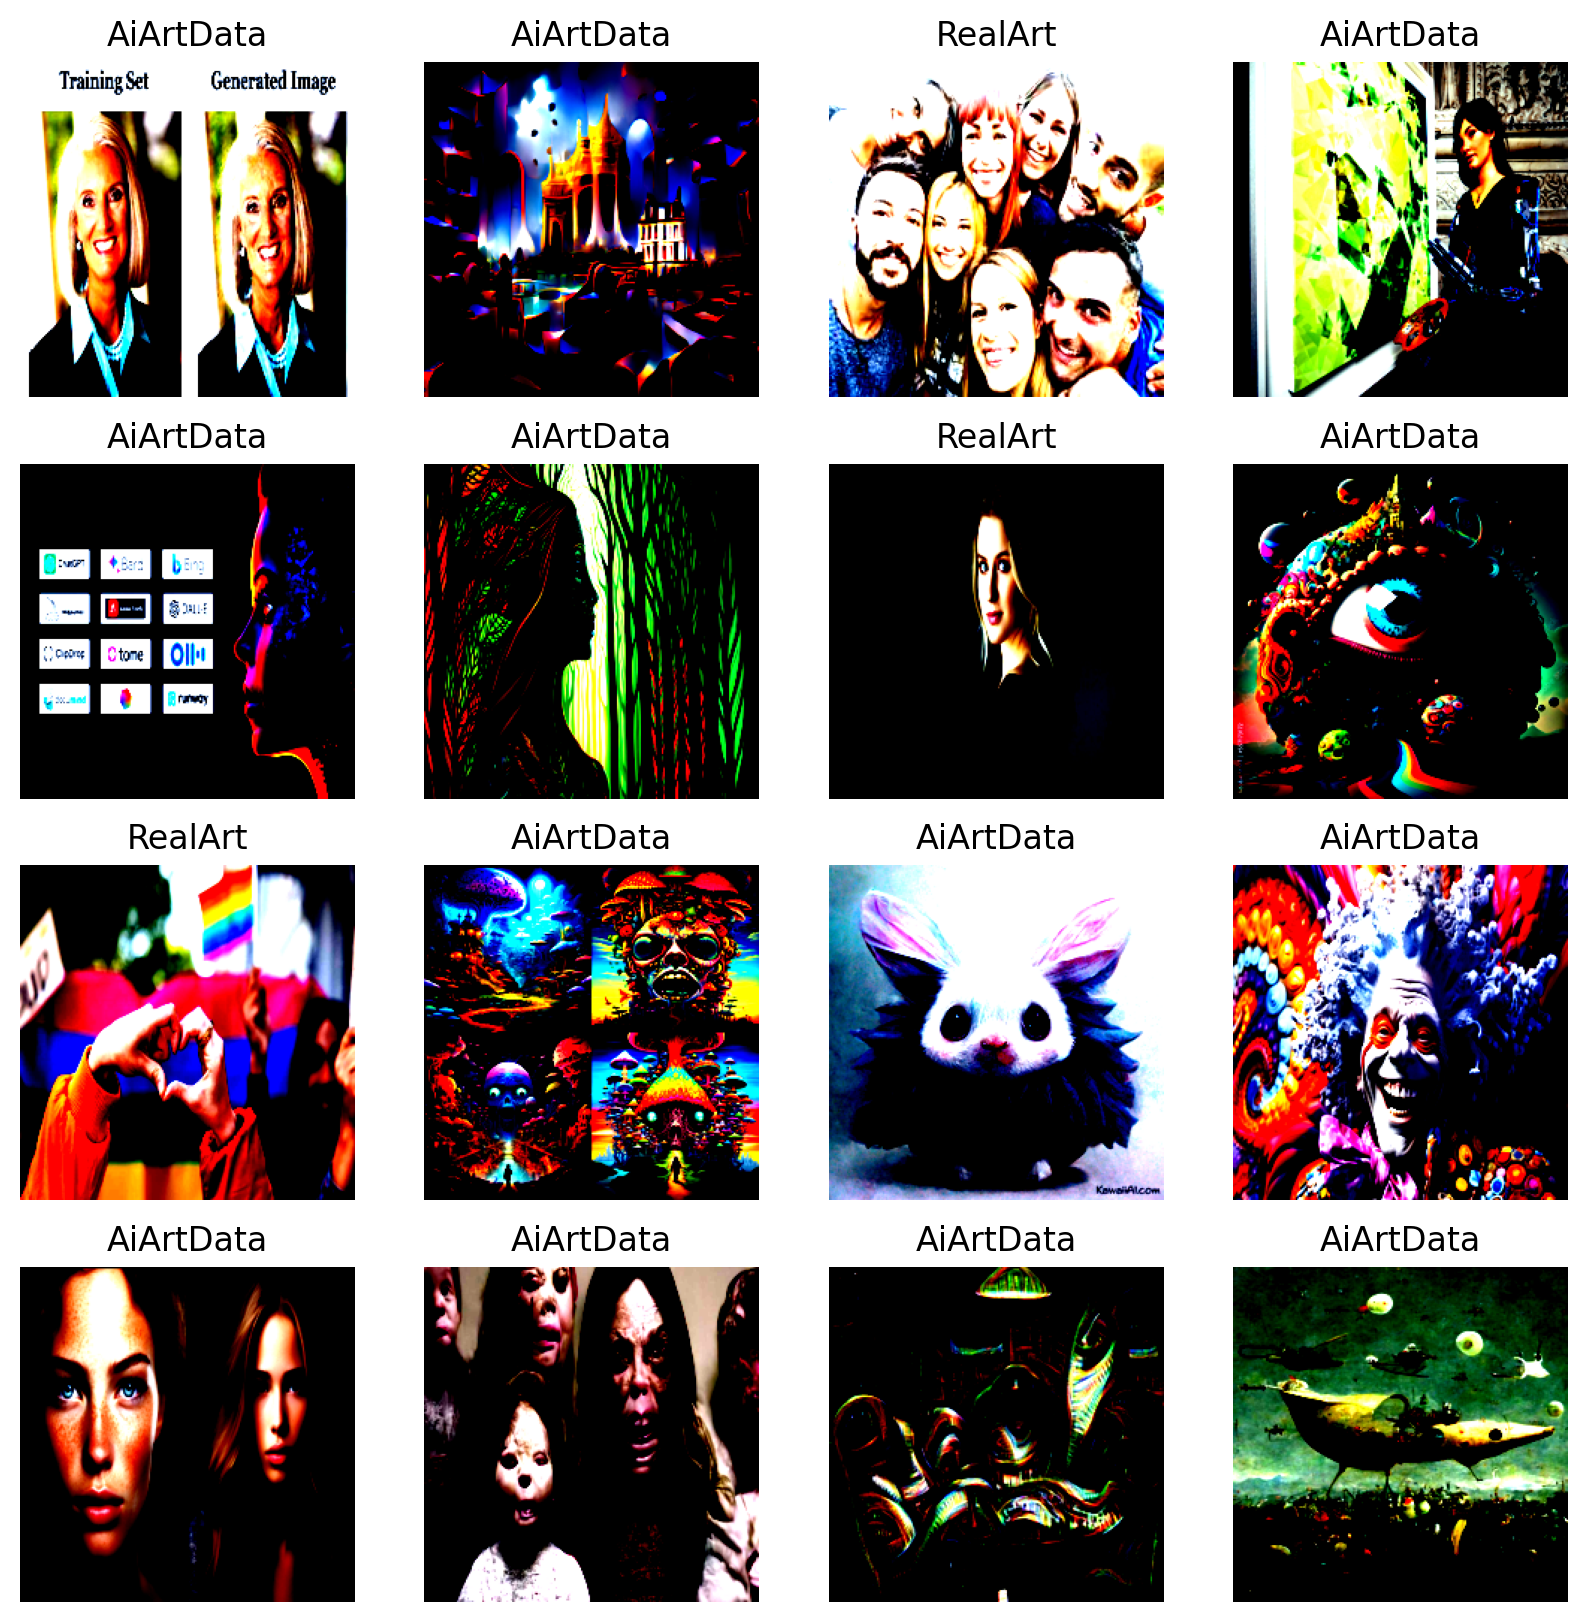

In [6]:
idx_cls = {idx: cls for cls, idx in dataset.class_to_idx.items()}
show_imgrid(dataset, idx_cls)

In [7]:
def class_distribution(dataset):
    classes_distr = defaultdict(int)
    for img, cls in dataset:
        classes_distr[cls] += 1
    classes = list(classes_distr.keys())
    cls_number = list(classes_distr.values())
    
    plt.bar(classes, cls_number)
    plt.title('Class distribution')
    plt.xticks(classes)
    plt.show()
    
    print(f"Total observations: {sum(cls_number)}")
    print("\nClass Distribution:")
    for cls, count in classes_distr.items():
        print(f"{cls}: {count} images ({(count / sum(cls_number)) * 100:.2f}%)")

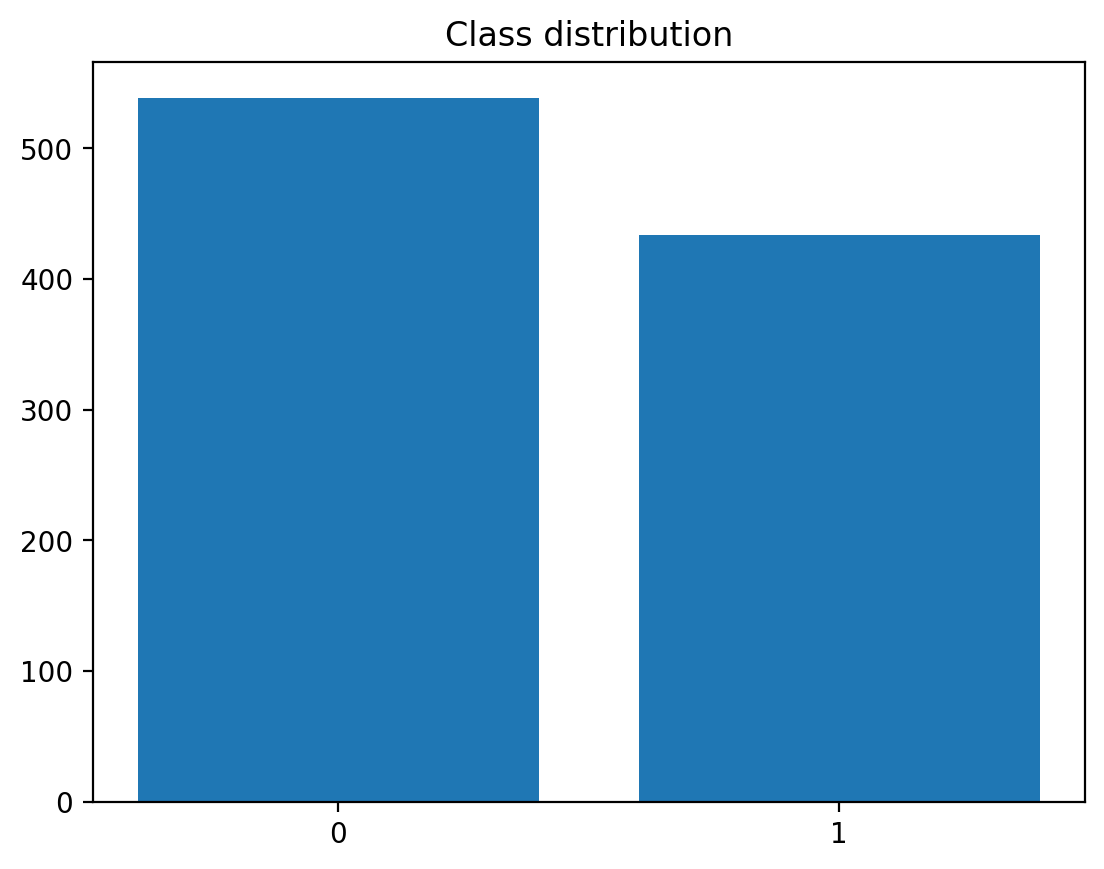

Total observations: 973

Class Distribution:
0: 539 images (55.40%)
1: 434 images (44.60%)


In [8]:
class_distribution(dataset)

## Define model

In [10]:
# https://github.com/google-research/big_transfer/tree/master?tab=readme-ov-file
# https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_pytorch.ipynb#scrollTo=y00wwFQvrwsX

In [9]:
import os
import sys
sys.path.append(project_path)

from model.BiT import ResNetV2
from model.utils import get_weights, train_model, test_model
from data.preprocessing import get_loaders

In [10]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
DEVICE

device(type='mps')

In [11]:
BATCH_SIZE = 32
train_loader, val_loader, test_loader = get_loaders(BATCH_SIZE)

Lengths:
Train = 681, Val = 145, Test = 147


In [12]:
if os.path.exists(os.path.join(project_path, 'model/weights/BiT-M-R50x1.npz')):
    weights = np.load(os.path.join(project_path, 'model/weights/BiT-M-R50x1.npz'))
else:
    weights = get_weights('BiT-M-R50x1')

In [13]:
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=2, zero_head=True)
model.load_from(weights)

ResNetV2(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, af

In [14]:
trained_model, _, _, _ = train_model(model, train_loader, val_loader, num_epochs=3)

Epoch 1
	Step: 0, Loss: 0.6931
	Step: 10, Loss: 0.6208
	Step: 20, Loss: 0.8920
Start evaluating
F1 score: 0.6609
Accuracy: 0.7310

Epoch 2
	Step: 0, Loss: 0.8362
	Step: 10, Loss: 0.2010
	Step: 20, Loss: 0.2596
Start evaluating
F1 score: 0.8321
Accuracy: 0.8414

Epoch 3
	Step: 0, Loss: 0.0959
	Step: 10, Loss: 0.1408
	Step: 20, Loss: 0.3352
Start evaluating
F1 score: 0.8261
Accuracy: 0.8345


In [16]:
test_model(trained_model, test_loader)

F1 score: 0.7874
Accuracy: 0.8163


(0.7874015748031497, 0.8163265306122449)

In [17]:
test_model(model, test_loader)

F1 score: 0.0000
Accuracy: 0.5374


(0.0, 0.5374149659863946)

In [19]:
torch.save(trained_model.state_dict(), os.path.join(project_path, 'model/weights/tunned_BiT.pt'))

In [28]:
torch.save(model.state_dict(), os.path.join(project_path, 'model/weights/raw_BiT.pt'))

In [21]:
loaded_model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=2, zero_head=True)
loaded_model.load_state_dict(torch.load(os.path.join(project_path, 'model/weights/tunned_BiT.pt')))

<All keys matched successfully>

In [22]:
test_model(loaded_model, test_loader)

F1 score: 0.7874
Accuracy: 0.8163


(0.7874015748031497, 0.8163265306122449)

## MLOps neptune.ai